##### Copyright 2019 Google LLC.


In [31]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Mesh Segmentation using Feature Steered Graph Convolutions

Segmenting a mesh to its semantic parts is an important problem for 3D shape
understanding. This colab demonstrates how to build a semantic mesh segmentation
model for deformable shapes using graph convolution layers defined in
[Tensorflow Graphics](https://github.com/tensorflow/graphics).

![](https://storage.googleapis.com/tensorflow-graphics/notebooks/mesh_segmentation/mesh_segmentation_demo.png)

This notebook covers the following key topics:
* How to use graph-convolutional layers to define a CNN for mesh segmentation.
* How to setup a data pipeline torepresent mesh connectivity with SparseTensors.

Note: The easiest way to use this tutorial is as a Colab notebook, which allows
you to dive in with no setup.

### Image Convolutions vs Graph Convolutions

Images are represented by uniform grids of pixels. Running convolutions on
uniform grids is a well understood process and is at the core of a significant
amount of products and academic publications.
![](https://storage.googleapis.com/tensorflow-graphics/notebooks/mesh_segmentation/cat_image_convolutions.png)

However, things become a bit more complicated when dealing with three
dimensional objects such as meshes or point clouds since these are not defined
on regular grids. A convolution operation for meshes or point clouds must
operate on irregular data structures. This makes convolutional neural
networks based on them harder to implement.
![](https://storage.googleapis.com/tensorflow-graphics/notebooks/mesh_segmentation/cat_mesh_convolutions.png)

Any general mesh can be denoted as a graph that is not constrained to a regular grid. Many graph-convolutional operators have been published in
the recent years. In this demo we use the method described in
[Feature Steered Graph Convolutions](https://arxiv.org/abs/1706.05206). Similar
to it's image counterpart, this basic building block can be used do solve a
plethora of problems. This Colab focusses on segmenting deformable meshes of
human bodies into parts (e.g. head, right foot, etc.).

## Setup & Imports

To run this Colab optimally, please update the runtime type to use a GPU
hardware accelerator. - click on the 'Runtime' menu, then 'Change runtime type':

![](https://storage.googleapis.com/tensorflow-graphics/notebooks/non_rigid_deformation/change_runtime.jpg)

-   finally, set the 'Hardware accelerator' to 'GPU'.

![](https://storage.googleapis.com/tensorflow-graphics/notebooks/mesh_segmentation/gpu_runtime.png)

If Tensorflow Graphics is not installed on your system, the following cell will
install the Tensorflow Graphics package for you.

Now that Tensorflow Graphics and dependencies are installed, let's import everything needed to run the demos contained in this notebook.

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import tensorflow as tf

from tensorflow_graphics.nn.layer import graph_convolution as graph_conv
from tensorflow_graphics.notebooks import mesh_segmentation_dataio as dataio
from tensorflow_graphics.notebooks import mesh_viewer
%load_ext tensorboard

import numpy as np
import trimesh
from mesh_viewer import *

import matplotlib.pyplot as plt
%matplotlib inline

In [128]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import tensorflow as tf

from tensorflow_graphics.geometry.convolution import utils as conv_utils
from tensorflow_graphics.geometry.representation.mesh import utils as mesh_utils
from tensorflow_graphics.util import shape

DEFAULT_IO_PARAMS = {
    'batch_size': 8,
    'shuffle_buffer_size': 100,
    'is_training': True,
    'parallel_threads': 5,
    'mean_center': True,
    'shuffle': None,
    'repeat': None,
}


def adjacency_from_edges(edges, weights, num_edges, num_vertices):
  """Returns a batched sparse 1-ring adj tensor from edge list tensor.
  Args:
    edges: [B, E, 2] `int32` tensor of edges, possibly 0 padded.
    weights: [B, E] `float32` tensor of edge weights, possibly 0 padded.
    num_edges: [B] `int32` tensor of number of valid edges per batch sample.
    num_vertices: [B] `int32` tensor of number of valid vertices per batch
      sample.
  Returns:
    adj: A batched SparseTensor of weighted adjacency graph, of
      dense_shape [B, V, V] where V is max(num_vertices)
  """
  edges = tf.convert_to_tensor(value=edges)
  weights = tf.convert_to_tensor(value=weights)
  num_edges = tf.convert_to_tensor(value=num_edges)
  num_vertices = tf.convert_to_tensor(value=num_vertices)

  if not edges.dtype.is_integer:
    raise TypeError("'edges' must have an integer type.")
  if not num_edges.dtype.is_integer:
    raise TypeError("'num_edges' must have an integer type.")
  if not num_vertices.dtype.is_integer:
    raise TypeError("'num_vertices' must have an integer type.")
  if not weights.dtype.is_floating:
    raise TypeError("'weights' must have a floating type.")

  shape.check_static(tensor=edges, tensor_name='edges', has_rank=3)
  shape.check_static(tensor=weights, tensor_name='weights', has_rank=2)
  shape.check_static(tensor=num_edges, tensor_name='num_edges', has_rank=1)
  shape.check_static(
      tensor=num_vertices, tensor_name='num_vertices', has_rank=1)
  shape.compare_dimensions(
      tensors=(edges, weights, num_edges, num_vertices),
      tensor_names=('edges', 'weights', 'num_edges', 'num_vertices'),
      axes=(-3, -2, -1, -1))
  shape.compare_dimensions(
      tensors=(edges, weights),
      tensor_names=('edges', 'weights'),
      axes=(-2, -1))

  batch_size = tf.shape(input=edges)[0]
  max_num_vertices = tf.reduce_max(input_tensor=num_vertices)
  max_num_edges = tf.shape(input=edges)[1]
  batch_col = tf.reshape(tf.range(batch_size, dtype=edges.dtype), [-1, 1, 1])
  batch_col = tf.tile(batch_col, [1, max_num_edges, 1])
  batch_edges = tf.concat([batch_col, edges], axis=-1)

  indices, _ = conv_utils.flatten_batch_to_2d(batch_edges, sizes=num_edges)
  values, _ = conv_utils.flatten_batch_to_2d(
      tf.expand_dims(weights, -1), sizes=num_edges)
  values = tf.squeeze(values)
  adjacency = tf.SparseTensor(
      indices=tf.cast(indices, tf.int64),
      values=values,
      dense_shape=[batch_size, max_num_vertices, max_num_vertices])
  adjacency = tf.sparse.reorder(adjacency)
  return adjacency


def get_weighted_edges(faces, self_edges=True):
  r"""Gets unique edges and degree weights from a triangular mesh.
  The shorthands used below are:
      `T`: The number of triangles in the mesh.
      `E`: The number of unique directed edges in the mesh.
  Args:
    faces: A [T, 3] `int32` numpy.ndarray of triangle vertex indices.
    self_edges: A `bool` flag. If true, then for every vertex 'i' an edge
      [i, i] is added to edge list.
  Returns:
    edges: A  [E, 2] `int32` numpy.ndarray of directed edges.
    weights: A [E] `float32` numpy.ndarray denoting edge weights.
    The degree of a vertex is the number of edges incident on the vertex,
    including any self-edges. The weight for an edge $w_{ij}$ connecting vertex
    $v_i$ and vertex $v_j$ is defined as,
    $$
    w_{ij} = 1.0 / degree(v_i)
    \sum_{j} w_{ij} = 1
    $$
  """
  edges = mesh_utils.extract_unique_edges_from_triangular_mesh(
      faces, directed_edges=True).astype(np.int32)
  if self_edges:
    vertices = np.expand_dims(np.unique(edges[:, 0]), axis=1)
    self_edges = np.concatenate((vertices, vertices), axis=1)
    edges = np.unique(np.concatenate((edges, self_edges), axis=0), axis=0)
  weights = mesh_utils.get_degree_based_edge_weights(edges, dtype=np.float32)
  return edges, weights


def _tfrecords_to_dataset(tfrecords,
                          parallel_threads,
                          shuffle,
                          repeat,
                          sloppy,
                          max_readers=16):
  """Creates a TFRecordsDataset that iterates over filenames in parallel.
  Args:
    tfrecords: A list of tf.Data.TFRecords filenames.
    parallel_threads: The `int` number denoting number of parallel worker
      threads.
    shuffle: The `bool` flag denoting whether to shuffle the dataset.
    repeat: The `bool` flag denoting whether to repeat the dataset.
    sloppy: The `bool` flag denoting if elements are produced in deterministic
      order.
    max_readers: The `int` number denoting the maximum number of input tfrecords
      to interleave from in parallel.
  Returns:
    A tf.data.TFRecordDataset
  """

  total_tfrecords = sum([len(tf.io.gfile.glob(f)) for f in tfrecords])
  num_readers = min(total_tfrecords, max_readers)
  dataset = tf.data.Dataset.list_files(tfrecords, shuffle=shuffle)
  if repeat:
    dataset = dataset.repeat()
  return dataset.apply(
      tf.data.experimental.parallel_interleave(
          tf.data.TFRecordDataset,
          num_readers,
          sloppy=sloppy,
          buffer_output_elements=parallel_threads,
          prefetch_input_elements=parallel_threads))


def _parse_tfex_proto(example_proto):
  """Parses the tfexample proto to a raw mesh_data dictionary.
  Args:
    example_proto: A tf.Example proto storing the encoded mesh data.
  Returns:
    A mesh data dictionary with the following fields:
      'num_vertices': The `int64` number of vertices in mesh.
      'num_triangles': The `int64` number of triangles in mesh.
      'vertices': A serialized tensor of vertex positions.
      'triangles': A serialized tensor of triangle vertex indices.
      'labels': A serialized tensor of per vertex class labels.
  """
  feature_description = {
      'num_vertices': tf.io.FixedLenFeature([], tf.int64, default_value=0),
      'num_triangles': tf.io.FixedLenFeature([], tf.int64, default_value=0),
      'vertices': tf.io.FixedLenFeature([], tf.string, default_value=''),
      'triangles': tf.io.FixedLenFeature([], tf.string, default_value=''),
      'labels': tf.io.FixedLenFeature([], tf.string, default_value=''),
  }
  return tf.io.parse_single_example(
      serialized=example_proto, features=feature_description)


def _parse_mesh_data(mesh_data, mean_center=True):
  """Parses a raw mesh_data dictionary read from tf examples.
  Args:
    mesh_data: A mesh data dictionary with serialized data tensors,
      as output from _parse_tfex_proto()
    mean_center: If true, centers the mesh vertices to mean(vertices).
  Returns:
     A mesh data dictionary with following fields:
      'num_vertices': The `int32` number of vertices in mesh.
      'num_triangles': The `int32` number of triangles in mesh.
      'num_edges': The `int32` number of unique directed edges in mesh.
      'vertices': A [V, 3] `float32` of vertex positions.
      'triangles': A [T, 3] `int32` tensor of triangle vertex indices.
      'labels': A [V] `int32` tensor of per vertex class labels.
      'edges': A [E, 2] `int32` tensor of unique directed edges in mesh.
      'edge_weights': A [E] `float32` tensor of vertex degree based edge
        weights.
  """
  labels = tf.io.parse_tensor(mesh_data['labels'], tf.int32)
  vertices = tf.io.parse_tensor(mesh_data['vertices'], tf.float32)
  triangles = tf.io.parse_tensor(mesh_data['triangles'], tf.int32)
  if mean_center:
    vertices = vertices - tf.reduce_mean(
        input_tensor=vertices, axis=0, keepdims=True)

  edges, weights = tf.py_function(
      func=lambda t: get_weighted_edges(t.numpy()),
      inp=[triangles],
      Tout=[tf.int32, tf.float32])

  num_edges = tf.shape(input=edges)[0]
  num_vertices = tf.cast(mesh_data['num_vertices'], tf.int32)
  num_triangles = tf.cast(mesh_data['num_triangles'], tf.int32)
  mesh_data = dict(
      vertices=vertices,
      labels=labels,
      triangles=triangles,
      edges=edges,
      edge_weights=weights,
      num_triangles=num_triangles,
      num_vertices=num_vertices,
      num_edges=num_edges)
  return mesh_data


def create_dataset_from_tfrecords(tfrecords, params):
  """Creates a mesh dataset given a list of tf records filenames.
  Args:
    tfrecords: A list of TFRecords filenames.
    params: A dictionary of IO paramaters, see DEFAULT_IO_PARAMS.
  Returns:
    A tf.data.Dataset, with each element a dictionary of batched mesh data
      with following fields:
      'vertices': A [B, V, 3] `float32` tensor of vertex positions, possibly
        0-padded.
      'triangles': A [B, T, 3] `int32` tensor of triangle vertex indices,
        possibly 0-padded
      'labels': A [B, V] `int32` tensor of per vertex class labels, possibly
        0-padded
      'edges': A [B, E, 2] `int32` tensor of unique directed edges in mesh,
        possibly 0-padded
      'edge_weights': A [B, E] `float32` tensor of vertex degree based edge
        weights, possibly 0-padded.
      'num_edges': A [B] `int32` tensor of number of unique directed edges in
        each mesh in the batch.
      'num_vertices':  A [B] `int32` tensor of number of vertices in each mesh
        in the batch.
      'num_triangles': A [B] `int32` tensor of number of triangles in each mesh
        in the batch.
  """

  def _set_default_if_none(param, param_dict, default_val):
    if param not in param_dict:
      return default_val
    else:
      return default_val if param_dict[param] is None else param_dict[param]

  is_training = params['is_training']
  shuffle = _set_default_if_none('shuffle', params, is_training)
  repeat = _set_default_if_none('repeat', params, is_training)
  sloppy = _set_default_if_none('sloppy', params, is_training)

  if not isinstance(tfrecords, list):
    tfrecords = [tfrecords]
  dataset = _tfrecords_to_dataset(tfrecords, params['parallel_threads'],
                                  shuffle, repeat, sloppy)
  dataset = dataset.map(_parse_tfex_proto, tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_mesh_data(x, mean_center=params['mean_center']),
      tf.data.experimental.AUTOTUNE)
  if repeat:
    dataset = dataset.repeat()
  if shuffle:
    dataset = dataset.shuffle(params['shuffle_buffer_size'])
  return dataset.padded_batch(
      params['batch_size'],
      padded_shapes={
          'vertices': [None, 3],
          'labels': [None],
          'triangles': [None, 3],
          'edges': [None, 2],
          'edge_weights': [None],
          'num_edges': [],
          'num_vertices': [],
          'num_triangles': [],
      },
      drop_remainder=is_training)


def create_input_from_dataset(dataset_fn, files, io_params):
  """Creates input function given dataset generator and input files.
  Args:
    dataset_fn: A dataset generator function.
    files: A list of TFRecords filenames.
    io_params: A dictionary of IO paramaters, see DEFAULT_IO_PARAMS.
  Returns:
    features: A dictionary of mesh data training features.
    labels: A [B] `int32` tensor of per vertex class labels.
  """
  for k in DEFAULT_IO_PARAMS:
    io_params[k] = io_params[k] if k in io_params else DEFAULT_IO_PARAMS[k]

  dataset = dataset_fn(files, io_params)
  mesh_data = tf.compat.v1.data.make_one_shot_iterator(dataset).get_next()
  mesh_data['neighbors'] = adjacency_from_edges(mesh_data['edges'],
                                                mesh_data['edge_weights'],
                                                mesh_data['num_edges'],
                                                mesh_data['num_vertices'])

  max_num_verts = tf.reduce_max(input_tensor=mesh_data['num_vertices'])
  features = dict(
      vertices=tf.reshape(mesh_data['vertices'], [-1, max_num_verts, 3]),
      triangles=mesh_data['triangles'],
      neighbors=mesh_data['neighbors'],
      edges=mesh_data['edges'],
      edge_weights=mesh_data['edge_weights'],
      num_triangles=mesh_data['num_triangles'],
      num_vertices=mesh_data['num_vertices'],
      extra=tf.shape(mesh_data['vertices'])
  )
  labels = mesh_data['labels']
  # Copy labels to features dictionary for estimator prediction mode.
  if not io_params['is_training']:
    features['labels'] = mesh_data['labels']
  return features, labels

Note this notebook works best in Graph mode.

### Fetch model files and data

For convenience, we provide a pre-trained model. Let's now download a pre-trained model checkpoint and the test data.

In [137]:
# path_to_model_zip = tf.keras.utils.get_file(
#     'model.zip',
#     origin='https://storage.googleapis.com/tensorflow-graphics/notebooks/mesh_segmentation/model.zip',
#     extract=True)

# path_to_data_zip = tf.keras.utils.get_file(
#     'data.zip',
#     origin='https://storage.googleapis.com/tensorflow-graphics/notebooks/mesh_segmentation/data.zip',
#     extract=True)

# local_model_dir = os.path.join(os.path.dirname(path_to_model_zip), 'model')
# test_data_files = [
#     os.path.join(
#         os.path.dirname(path_to_data_zip),
#         'data/Dancer_test_sequence.tfrecords')
# ]

test_data_files = ['Dancer_test_sequence.tfrecords']

## Load and visualize test data

For graph convolutions, we need a *weighted adjacency matrix* denoting the mesh
connectivity. Feature-steered graph convolutions expect self-edges in the mesh
connectivity for each vertex, i.e. the diagonal of the weighted adjacency matrix
should be non-zero. This matrix is defined as:
```
A[i, j] = w[i,j] if vertex i and vertex j share an edge,
A[i, i] = w[i,i] for each vertex i,
A[i, j] = 0 otherwise.
where, w[i, j] = 1/(degree(vertex i)), and sum(j)(w[i,j]) = 1
```
Here degree(vertex i) is the number of edges incident on a vertex (including the
self-edge). This weighted adjacency matrix is stored as a SparseTensor.

We will load the test meshes from the test [tf.data.TFRecordDataset](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset)
downloaded above. Each mesh is stored as a
[tf.Example](https://www.tensorflow.org/api_docs/python/tf/train/Example), with
the following fields:

*   'num_vertices': Number of vertices in each mesh
*   'num_triangles': Number of triangles in each mesh.
*   'vertices': A [V, 3] float tensor of vertex positions.
*   'triangles': A [T, 3] integer tensor of vertex indices for each triangle.
*   'labels': A [V] integer tensor with segmentation class label for each
    vertex.

where 'V' is number of vertices and 'T' is number of triangles in the mesh. As
each mesh may have a varying number of vertices and faces (and the corresponding
connectivity matrix), we pad the data tensors with '0's in each batch.

For details on the dataset pipeline implementation, take a look at
mesh_segmentation_dataio.py.

Lets try to load a batch from the test TFRecordDataset, and visualize the first
mesh with each vertex colored by the part label.

In [138]:
test_io_params = {
    'is_training': False,
    'sloppy': False,
    'shuffle': True,
}
test_tfrecords = test_data_files

input_graph = tf.Graph()
with input_graph.as_default():
  mesh_load_op = create_input_from_dataset(
      create_dataset_from_tfrecords, test_tfrecords, test_io_params)
  with tf.Session() as sess:
    test_mesh_data, test_labels = sess.run(mesh_load_op)

>>> Current Index: 0
>>>> Vertices: 2652 / 2663
>>>> Faces: 3999 / 4000


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…

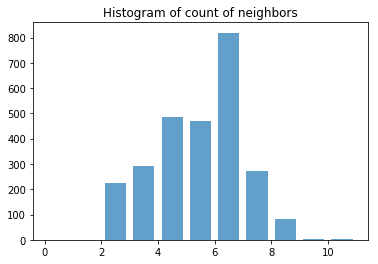

[  0.   0. 223. 291. 484. 471. 819. 272.  84.   4.   2.]


In [139]:
if 'cur_idx' not in locals() and 'cur_idx' not in globals():
  cur_idx = 0
    
if cur_idx >= test_mesh_data['num_vertices'].shape[0]:
  cur_idx = 0

print(">>> Current Index: %d" % cur_idx)
print(">>>> Vertices: %d / %d" % (test_mesh_data['num_vertices'][cur_idx], test_mesh_data["vertices"][cur_idx].shape[0]))
print(">>>> Faces: %d / %d" % (test_mesh_data["num_triangles"][cur_idx], test_mesh_data["triangles"][cur_idx].shape[0]))

input_mesh_data = {
    'vertices': test_mesh_data['vertices'][cur_idx],
    'faces': test_mesh_data['triangles'][cur_idx],
    'vertex_colors': mesh_viewer.SEGMENTATION_COLORMAP[test_labels[cur_idx]],
}
display_mesh(input_mesh_data)

mesh = trimesh.Trimesh(vertices=test_mesh_data['vertices'][cur_idx][:test_mesh_data['num_vertices'][cur_idx]],
                       faces=test_mesh_data['triangles'][cur_idx][:test_mesh_data['num_triangles'][cur_idx]])
neighbor_num = [len(v) for v in mesh.vertex_neighbors]
hist, bins, _ = plt.hist(neighbor_num, bins=range(12), alpha=0.7, rwidth=0.75)  # arguments are passed to np.histogram
plt.title("Histogram of count of neighbors")
plt.show()

# hist, bins = np.histogram(neighbor_num, bins=range(12))
print(hist)

cur_idx += 1

## Model Definition

Given a mesh with V vertices and D-dimensional per-vertex input features (e.g.
vertex position, normal), we would like to create a network capable of
classifying each vertex to a part label. Lets first create a mesh encoder that
encodes each vertex in the mesh into C-dimensional logits, where C is the number
of parts. First we use 1x1 convolutions to change input feature dimensions,
followed by a sequence of feature steered graph convolutions and ReLU
non-linearities, and finally 1x1 convolutions to logits, which are used for
computing softmax cross entropy as described below.

Note that this model does not use any form of pooling, which is outside the scope of this notebook.

![](https://storage.googleapis.com/tensorflow-graphics/notebooks/mesh_segmentation/mesh_segmentation_model_def.png)

In [24]:
MODEL_PARAMS = {
    'num_filters': 8,
    'num_classes': 2,
    'encoder_filter_dims': [32, 64, 128],
    
    # Adam Optimizer
    'learning_rate': 0.001,
    'beta': 0.9,
    'adam_epsilon': 1e-08
}


def mesh_encoder(batch_mesh_data, num_filters, output_dim, conv_layer_dims):
  """A mesh encoder using feature steered graph convolutions.

    The shorthands used below are
      `B`: Batch size.
      `V`: The maximum number of vertices over all meshes in the batch.
      `D`: The number of dimensions of input vertex features, D=3 if vertex
        positions are used as features.

  Args:
    batch_mesh_data: A mesh_data dict with following keys
      'vertices': A [B, V, D] `float32` tensor of vertex features, possibly
        0-padded.
      'neighbors': A [B, V, V] `float32` sparse tensor of edge weights.
      'num_vertices': A [B] `int32` tensor of number of vertices per mesh.
    num_filters: The number of weight matrices to be used in feature steered
      graph conv.
    output_dim: A dimension of output per vertex features.
    conv_layer_dims: A list of dimensions used in graph convolution layers.

  Returns:
    vertex_features: A [B, V, output_dim] `float32` tensor of per vertex
      features.
  """
  batch_vertices = batch_mesh_data['vertices']

  # Linear: N x D --> N x 16.
  vertex_features = tf.keras.layers.Conv1D(16, 1, name='lin16')(batch_vertices)

  # graph convolution layers
  for dim in conv_layer_dims:
    with tf.variable_scope('conv_%d' % dim):
      vertex_features = graph_conv.feature_steered_convolution_layer(
          vertex_features,
          batch_mesh_data['neighbors'],
          batch_mesh_data['num_vertices'],
          num_weight_matrices=num_filters,
          num_output_channels=dim)
    vertex_features = tf.nn.relu(vertex_features)

  # Linear: N x 128 --> N x 256.
  vertex_features = tf.keras.layers.Conv1D(
      256, 1, name='lin256')(
          vertex_features)
  vertex_features = tf.nn.relu(vertex_features)

  # Linear: N x 256 --> N x output_dim.
  vertex_features = tf.keras.layers.Conv1D(
      output_dim, 1, name='lin_output')(
          vertex_features)

  return vertex_features

Given a mesh encoder, let's define a model_fn for a custom
[tf.Estimator](https://www.tensorflow.org/api_docs/python/tf/estimator/Estimator)
for vertex classification using softmax cross entropy loss. A tf.Estimator model_fn returns the ops necessary to perform training, evaluation, or predictions given inputs and a number of other parameters. Recall that the
vertex tensor may be zero-padded (see Dataset Pipeline above), hence we must mask out the contribution from the padded values.

In [25]:
def model_fn(features, labels, mode, params):
  """Returns a mesh segmentation model_fn for use with tf.Estimator."""
  logits = mesh_encoder(features, params['num_filters'], params['num_classes'],
                        params['encoder_filter_dims'])
  predictions = tf.argmax(logits, axis=-1, output_type=tf.int32)
  outputs = {
      'vertices': features['vertices'],
      'triangles': features['triangles'],
      'num_vertices': features['num_vertices'],
      'num_triangles': features['num_triangles'],
      'predictions': predictions
  }
  # For predictions, return the outputs.
  if mode == tf.estimator.ModeKeys.PREDICT:
    outputs['labels'] = features['labels']
    return tf.estimator.EstimatorSpec(mode=mode, predictions=outputs)
  # Loss
  # Weight the losses by masking out padded vertices/labels.
  vertex_ragged_sizes = features['num_vertices']
  mask = tf.sequence_mask(vertex_ragged_sizes, tf.shape(labels)[-1])
  loss_weights = tf.cast(mask, dtype=tf.float32)
  loss = tf.losses.sparse_softmax_cross_entropy(
      logits=logits, labels=labels, weights=loss_weights)
  # For training, build the optimizer.
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.AdamOptimizer(
        learning_rate=params['learning_rate'],
        beta1=params['beta'],
        epsilon=params['adam_epsilon'])
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
      train_op = optimizer.minimize(
          loss=loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # For eval, return eval metrics.
  eval_ops = {
      'mean_loss':
          tf.metrics.mean(loss),
      'accuracy':
          tf.metrics.accuracy(
              labels=labels, predictions=predictions, weights=loss_weights)
  }
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_ops)

## Test model & visualize results

Now that we have defined the model, let's load the weights from the trained model downloaded above and use tf.Estimator.predict to predict the part labels for meshes in the test dataset.

In [142]:
test_io_params = {
    'is_training': False,
    'sloppy': False,
    'shuffle': True,
    'repeat': False,
    'batch_size': 2
}
test_tfrecords = test_data_files
print(test_tfrecords)

def predict_fn():
  return create_input_from_dataset(create_dataset_from_tfrecords,
                                          test_tfrecords,
                                          test_io_params)


estimator = tf.estimator.Estimator(model_fn=model_fn,
                                   model_dir=local_model_dir,
                                   params=MODEL_PARAMS)
test_predictions = estimator.predict(input_fn=predict_fn)

['Dancer_test_sequence.tfrecords']


Run the following cell repeatedly to cycle through the meshes in the test sequence. The left view shows the input mesh, and the right view shows the predicted part labels.

In [143]:
prediction = next(test_predictions)
# print(prediction["extra"])
input_mesh_data = {
    'vertices': prediction['vertices'],
    'faces': prediction['triangles'],
}
predicted_mesh_data = {
    'vertices': prediction['vertices'],
    'faces': prediction['triangles'],
    'vertex_colors': mesh_viewer.SEGMENTATION_COLORMAP[prediction['predictions']],
}

display_mesh(input_mesh_data)
display_mesh(predicted_mesh_data)

Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…

Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…

0


# Experiments on psbCup Dataset

In [26]:
test_io_params = {
    'is_training': False,
    'sloppy': False,
    'shuffle': True,
}
test_tfrecords = ['psbCup.train.tfrecords', 'psbCup.test.tfrecords']

input_graph = tf.Graph()
with input_graph.as_default():
  mesh_load_op = dataio.create_input_from_dataset(
      dataio.create_dataset_from_tfrecords, test_tfrecords, test_io_params)
  with tf.Session() as sess:
    test_mesh_data, test_labels = sess.run(mesh_load_op)
    
input_mesh_data = {
    'vertices': test_mesh_data['vertices'][0],
    'faces': test_mesh_data['triangles'][0],
    'vertex_colors': mesh_viewer.SEGMENTATION_COLORMAP[test_labels[0]],
}
display_mesh(input_mesh_data)

Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…

## Train Cup Model

In [28]:
train_io_params = {
    'is_training': True,
    'sloppy': False,
    'shuffle': True,
    'repeat': True,
    'batch_size': 5
}
train_tfrecords = ['psbCup.train.tfrecords']

tf.logging.set_verbosity(tf.logging.INFO)

def train_fn():
  return dataio.create_input_from_dataset(dataio.create_dataset_from_tfrecords,
                                          train_tfrecords,
                                          train_io_params)
local_model_dir = "./psbCup_model"

estimator = tf.estimator.Estimator(model_fn=model_fn,
                                   model_dir=local_model_dir,
                                   params=MODEL_PARAMS)
estimator.train(input_fn=train_fn, steps=1000)

I0814 21:28:03.297755 4694070720 estimator.py:1790] Using default config.
I0814 21:28:03.300096 4694070720 estimator.py:209] Using config: {'_model_dir': './psbCup_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x140577ba8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
I0814 21:28:03.490075 46940707

## Test Cup Model

In [46]:
test_io_params = {
    'is_training': False,
    'sloppy': False,
    'shuffle': True,
}
test_tfrecords = ['psbCup.test.tfrecords']

def predict_fn():
  return dataio.create_input_from_dataset(dataio.create_dataset_from_tfrecords,
                                          test_tfrecords,
                                          test_io_params)
local_model_dir = "./psbCup_model"

estimator = tf.estimator.Estimator(model_fn=model_fn,
                                   model_dir=local_model_dir,
                                   params=MODEL_PARAMS)
test_predictions = estimator.predict(input_fn=predict_fn)

I0815 11:15:52.546389 4694070720 estimator.py:1790] Using default config.
I0815 11:15:52.549541 4694070720 estimator.py:209] Using config: {'_model_dir': './psbCup_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13def5ef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [47]:
prediction = next(test_predictions)
# print(prediction["extra"])
input_mesh_data = {
    'vertices': prediction['vertices'],
    'faces': prediction['triangles'],
}
predicted_mesh_data = {
    'vertices': prediction['vertices'],
    'faces': prediction['triangles'],
    'vertex_colors': mesh_viewer.SEGMENTATION_COLORMAP[prediction['predictions']],
}

display_mesh(input_mesh_data)
display_mesh(predicted_mesh_data)

I0815 11:15:53.660799 4694070720 estimator.py:1145] Calling model_fn.
I0815 11:15:54.147382 4694070720 estimator.py:1147] Done calling model_fn.
I0815 11:15:54.236064 4694070720 monitored_session.py:240] Graph was finalized.
I0815 11:15:54.241089 4694070720 saver.py:1280] Restoring parameters from ./psbCup_model/model.ckpt-1325
I0815 11:15:54.421657 4694070720 session_manager.py:500] Running local_init_op.
I0815 11:15:54.448805 4694070720 session_manager.py:502] Done running local_init_op.


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…

Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…

# Test with Our Model 

In [28]:
mesh = trimesh.load("../meshes/f_c_10412256613_model.obj")
mesh_data = {
    'vertices': mesh.vertices,
    'faces': mesh.faces
}
display_mesh(mesh_data)

Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…

In [25]:
mean_center = True

def mesh_to_features(mesh):
  labels = tf.zeros(mesh.vertices.shape[0], tf.int32)
  vertices = tf.convert_to_tensor(mesh.vertices, dtype=tf.float32)
  num_vertices = tf.shape(input=vertices)[0]
  if mean_center:
    vertices = vertices - tf.reduce_mean(input_tensor=vertices, axis=0, keepdims=True)

  triangles = tf.convert_to_tensor(mesh.faces, dtype=tf.int32)
  num_triangles = tf.shape(input=triangles)[0]

  edges, edge_weights = tf.py_function(
    func=lambda t: dataio.get_weighted_edges(t.numpy()),
    inp=[triangles],
    Tout=[tf.int32, tf.float32]
  )
  num_edges = tf.shape(input=edges)[0]

  vertices=tf.reshape(vertices, [1, -1, 3])
  triangles=tf.reshape(triangles, [1, -1, 3])
  edges=tf.reshape(edges, [1, -1, 2])
  edge_weights=tf.reshape(edge_weights, [1, -1])
  labels = tf.reshape(labels, [1, -1])
  
  num_vertices = tf.reshape(num_vertices, [1])
  num_triangles = tf.reshape(num_triangles, [1])
  num_edges = tf.reshape(num_edges, [1])

#     paddings = tf.constant([[0, 2667 - vertices.shape[0]], [0, 0]])
#     vertices = tf.pad(vertices, paddings, "CONSTANT")

#     paddings = tf.constant([[0, 4000 - triangles.shape[0]], [0, 0]])
#     triangles = tf.pad(vertices, paddings, "CONSTANT")

#     paddings = tf.constant([[0, 15877 - edges.shape[0]], [0, 0]])
#     edges = tf.pad(edges, paddings, "CONSTANT")

#     paddings = tf.constant([[0, 15877 - weights.shape[0]], [0, 0]])
#     weights = tf.pad(weights, paddings, "CONSTANT")

  neighbors = dataio.adjacency_from_edges(
    edges,
    edge_weights,
    num_edges,
    num_vertices
  )


  features = dict(
    vertices=vertices,
    triangles=triangles,
    neighbors=neighbors,
    num_triangles=num_triangles,
    num_vertices=num_vertices,
    labels=labels
  )


#   return labels, vertices, triangles, edges, edge_weights, neighbors
  return features, labels

# input_graph = tf.Graph()
# with input_graph.as_default():
#   with tf.Session() as sess:
#     mesh_op = handle(mesh)
#     labels, vertices, triangles, edges, weights, neighbors = sess.run(mesh_op)

#     print(vertices.shape)
#     print(edges.shape)
#     print(weights.shape)
#     print(neighbors)
    
# mesh_data = {
#     'vertices': vertices,
#     'faces': triangles
# }
# input_viewer = mesh_viewer.Viewer(mesh_data)


In [29]:
def my_predict_fn():
  return mesh_to_features(mesh)


my_estimator = tf.estimator.Estimator(model_fn=model_fn,
                                   model_dir=local_model_dir,
                                   params=MODEL_PARAMS)
my_test_predictions = my_estimator.predict(input_fn=my_predict_fn)

In [30]:
prediction = next(my_test_predictions)
print(">>>> Vertices: %d / %d" % (prediction["num_vertices"], prediction["vertices"].shape[0]))
print(">>>> Faces: %d / %d" % (prediction["num_triangles"], prediction["triangles"].shape[0]))

input_mesh_data = {
    'vertices': prediction['vertices'],
    'faces': prediction['triangles'],
}
predicted_mesh_data = {
    'vertices': prediction['vertices'],
    'faces': prediction['triangles'],
    'vertex_colors': mesh_viewer.SEGMENTATION_COLORMAP[prediction['predictions']],
}

display_mesh(input_mesh_data)
display_mesh(predicted_mesh_data)

W0808 17:41:16.844424 4485752256 estimator.py:1000] Input graph does not use tf.data.Dataset or contain a QueueRunner. That means predict yields forever. This is probably a mistake.


>>>> Vertices: 67149 / 67149
>>>> Faces: 100000 / 100000


Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…

Renderer(background='#dddddd', camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(position=(-30.0…